# Monte Carlo for Vector Functions of Integrals

Demo Accompanying [Aleksei Sorokin's PyData Chicago 2023 Talk](https://www.meetup.com/pydatachi/events/292071593/)

---

## Monte Carlo Problem

$$\text{True Mean} = \mu = \mathbb{E}[g(T)] = \mathbb{E}[f(X)] = \int_{[0,1]^d} f(x) \mathrm{d} x \approx \frac{1}{n} \sum_{i=0}^{n-1} f(X_i) = \hat{\mu} = \text{Sample Mean}$$

- $T$, original measure on $\mathcal{T}$
- $g: \mathcal{T} \to \mathbb{R}$, original integrand
- $X \sim \mathcal{U}[0,1]^d$, transformed measure
- $f: [0,1]^d \to \mathbb{R}$, transformed integrand

## Python Setup

In [1]:
import qmcpy as qp
import numpy as np
import scipy.stats
import time
from matplotlib import pyplot
pyplot.style.use('../qmcpy.mplstyle')
colors = pyplot.rcParams['axes.prop_cycle'].by_key()['color']
%matplotlib inline

## Discrete Distribution

Generate sampling locations $X_0,\dots,X_{n-1} \sim \mathcal{U}[0,1]^d$

### Independent Identically Distributed (IID) Points for Crude Monte Carlo (CMC)

In [2]:
iid = qp.IIDStdUniform(dimension=3)
iid.gen_samples(n=4)

array([[3.61716300e-02, 2.10635639e-01, 8.46718223e-01],
       [9.05893082e-01, 8.90196371e-04, 7.52947702e-01],
       [3.47551917e-01, 5.09620143e-01, 8.63154944e-01],
       [5.79773473e-01, 3.69135487e-01, 1.41853459e-01]])

In [3]:
iid.gen_samples(4)

array([[0.10735139, 0.46046756, 0.17225848],
       [0.84500309, 0.17350993, 0.65185055],
       [0.54830002, 0.21116433, 0.349431  ],
       [0.95355934, 0.51085886, 0.96648051]])

In [4]:
iid

IIDStdUniform (DiscreteDistribution Object)
    d               3
    entropy         135921352538353208827149100887817052277
    spawn_key       ()

### Low Discrepancy (LD) Points for Quasi-Monte Carlo (QMC)

In [5]:
ld_lattice = qp.Lattice(3)
ld_lattice.gen_samples(4)

array([[0.63454691, 0.87104425, 0.07261723],
       [0.13454691, 0.37104425, 0.57261723],
       [0.88454691, 0.62104425, 0.82261723],
       [0.38454691, 0.12104425, 0.32261723]])

In [6]:
ld_lattice.gen_samples(4)

array([[0.63454691, 0.87104425, 0.07261723],
       [0.13454691, 0.37104425, 0.57261723],
       [0.88454691, 0.62104425, 0.82261723],
       [0.38454691, 0.12104425, 0.32261723]])

In [7]:
ld_lattice.gen_samples(n_min=2,n_max=4)

array([[0.88454691, 0.62104425, 0.82261723],
       [0.38454691, 0.12104425, 0.32261723]])

In [8]:
ld_lattice

Lattice (DiscreteDistribution Object)
    d               3
    dvec            [0 1 2]
    randomize       1
    order           natural
    gen_vec         [     1 182667 469891]
    entropy         315579500516060866354658995969989914841
    spawn_key       ()

### Visuals

#### IID vs LD Points

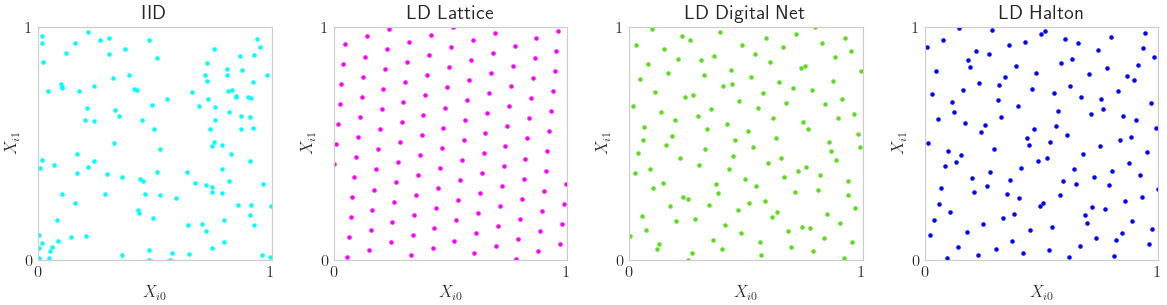

In [9]:
n = 2**7 # Lattice and Digital Net prefer powers of 2 sample sizes
discrete_distribs = {
    'IID': qp.IIDStdUniform(2),
    'LD Lattice': qp.Lattice(2),
    'LD Digital Net': qp.DigitalNetB2(2),
    'LD Halton': qp.Halton(2)}
fig,ax = pyplot.subplots(nrows=1,ncols=len(discrete_distribs),figsize=(3*len(discrete_distribs),3))
ax = np.atleast_1d(ax)
for i,(name,discrete_distrib) in enumerate(discrete_distribs.items()):
    x = discrete_distrib.gen_samples(n)
    ax[i].scatter(x[:,0],x[:,1],s=5,color=colors[i])
    ax[i].set_title(name)
    ax[i].set_aspect(1)
    ax[i].set_xlabel(r'$X_{i0}$'); ax[i].set_ylabel(r'$X_{i1}$')
    ax[i].set_xlim([0,1]); ax[i].set_ylim([0,1])
    ax[i].set_xticks([0,1]); ax[i].set_yticks([0,1])

#### LD Space Filling Extensibility

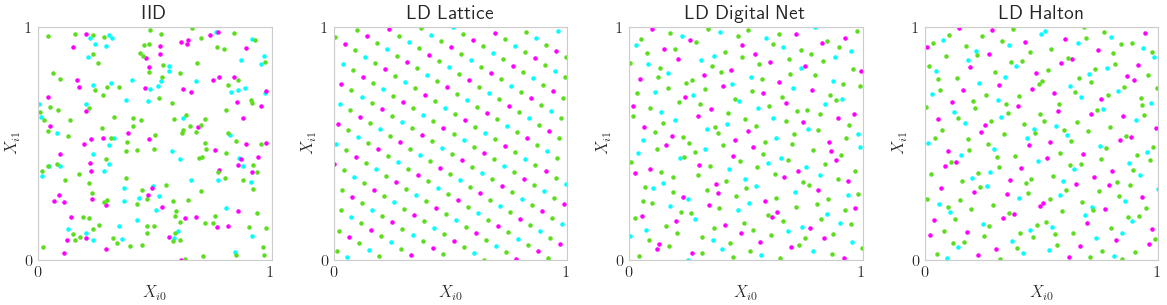

In [10]:
m_min,m_max = 6,8
fig,ax = pyplot.subplots(nrows=1,ncols=len(discrete_distribs),figsize=(3*len(discrete_distribs),3))
ax = np.atleast_1d(ax)
for i,(name,discrete_distrib) in enumerate(discrete_distribs.items()):
    x = discrete_distrib.gen_samples(2**m_max)
    n_min = 0
    for m in range(m_min,m_max+1):
        n_max = 2**m
        ax[i].scatter(x[n_min:n_max,0],x[n_min:n_max,1],s=5,color=colors[m-m_min],label='n_min = %d, n_max = %d'%(n_min,n_max))
        n_min = 2**m
    ax[i].set_title(name)
    ax[i].set_aspect(1)
    ax[i].set_xlabel(r'$X_{i0}$'); ax[i].set_ylabel(r'$X_{i1}$')
    ax[i].set_xlim([0,1]); ax[i].set_ylim([0,1])
    ax[i].set_xticks([0,1]); ax[i].set_yticks([0,1])

#### High Dimensional Pairs Plotting

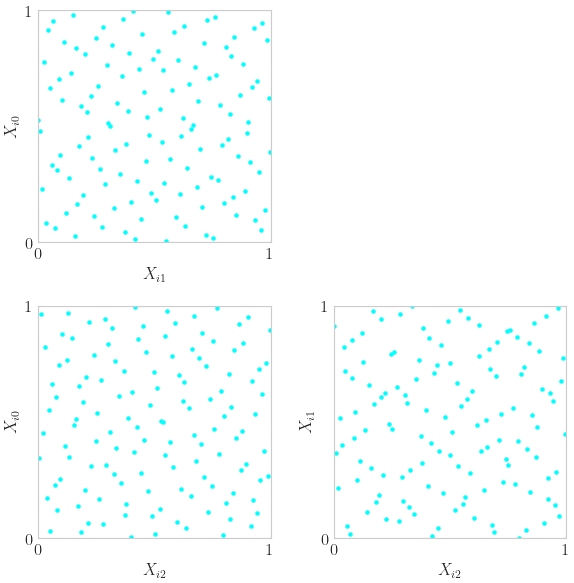

In [11]:
discrete_distrib = qp.DigitalNetB2(3)
x = discrete_distrib(2**7)
d = discrete_distrib.d
assert d>=2
fig,ax = pyplot.subplots(nrows=d,ncols=d,figsize=(3*d,3*d))
for i in range(d):
    fig.delaxes(ax[i,i])
    for j in range(i):
        ax[i,j].scatter(x[:,i],x[:,j],s=5)
        fig.delaxes(ax[j,i])
        ax[i,j].set_aspect(1)
        ax[i,j].set_xlabel(r'$X_{i%d}$'%i); ax[i,j].set_ylabel(r'$X_{i%d}$'%j)
        ax[i,j].set_xlim([0,1]); ax[i,j].set_ylim([0,1])
        ax[i,j].set_xticks([0,1]); ax[i,j].set_yticks([0,1])

## True Measure

Define $T$, facilitate transform from original integrand $g$ to transformed integrand $f$

In [12]:
discrete_distrib = qp.Halton(3)
true_measure = qp.Gaussian(discrete_distrib,mean=[1,2,3],covariance=[4,5,6])
true_measure.gen_samples(4)

array([[ 2.53804675,  0.58469206,  3.79941192],
       [ 0.38410049,  2.54752676,  0.21673774],
       [ 5.06943246,  5.30082634,  5.8528442 ],
       [ 1.39898008, -1.88483605,  2.23835782]])

In [13]:
true_measure.gen_samples(n_min=2,n_max=4)

array([[ 5.06943246,  5.30082634,  5.8528442 ],
       [ 1.39898008, -1.88483605,  2.23835782]])

In [14]:
true_measure

Gaussian (TrueMeasure Object)
    mean            [1 2 3]
    covariance      [4 5 6]
    decomp_type     PCA

### Visuals

#### Some True Measure Samplings

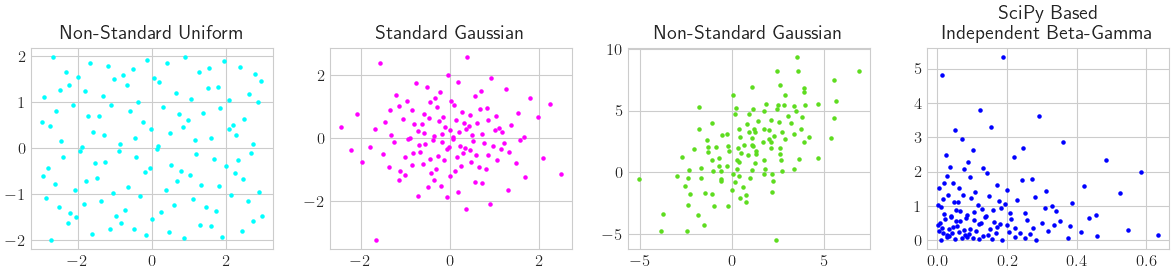

In [15]:
n = 2**7
discrete_distrib = qp.DigitalNetB2(2)
true_measures = {
    'Non-Standard Uniform': qp.Uniform(discrete_distrib,lower_bound=[-3,-2],upper_bound=[3,2]),
    'Standard Gaussian': qp.Gaussian(discrete_distrib),
    'Non-Standard Gaussian': qp.Gaussian(discrete_distrib,mean=[1,2],covariance=[[5,4],[4,9]]),
    'SciPy Based\nIndependent Beta-Gamma': qp.SciPyWrapper(discrete_distrib,[scipy.stats.beta(a=1,b=5),scipy.stats.gamma(a=1)])}
fig,ax = pyplot.subplots(nrows=1,ncols=len(true_measures),figsize=(3*len(true_measures),3))
ax = np.atleast_1d(ax)
for i,(name,true_measure) in enumerate(true_measures.items()):
    t = true_measure.gen_samples(n)
    ax[i].scatter(t[:,0],t[:,1],s=5,color=colors[i])
    ax[i].set_title(name)    

#### Brownian Motion

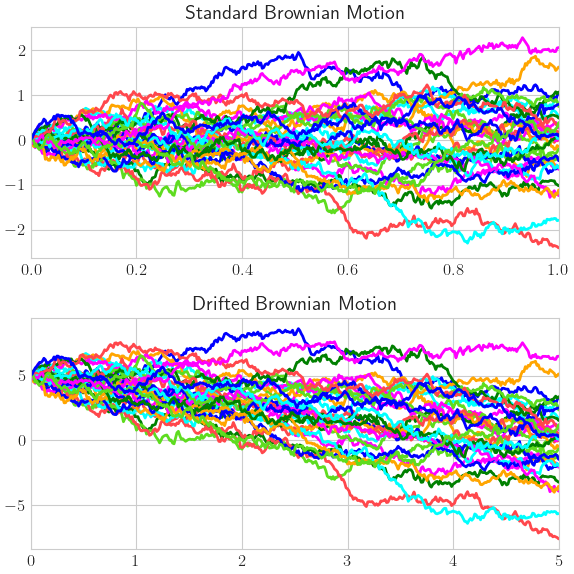

In [16]:
n = 32
discrete_distrib = qp.Lattice(365)
brownian_motions = {
    'Standard Brownian Motion': qp.BrownianMotion(discrete_distrib),
    'Drifted Brownian Motion': qp.BrownianMotion(discrete_distrib,t_final=5,initial_value=5,drift=-1,diffusion=2)}
fig,ax = pyplot.subplots(nrows=len(brownian_motions),ncols=1,figsize=(6,3*len(brownian_motions)))
ax = np.atleast_1d(ax)
for i,(name,brownian_motion) in enumerate(brownian_motions.items()):
    t = brownian_motion.gen_samples(n)
    t_w_init = np.hstack([brownian_motion.initial_value*np.ones((n,1)),t])
    tvec_w_0 = np.hstack([0,brownian_motion.time_vec])
    ax[i].plot(tvec_w_0,t_w_init.T)
    ax[i].set_xlim([tvec_w_0[0],tvec_w_0[-1]])
    ax[i].set_title(name)

## Integrand

Define original integrand $g$, store transformed integrand $f$

### Wrap your Function into QMCPy

Our simple example
$$g(T) = T_0+T_1+\dots+T_{d-1}, \qquad T \sim \mathcal{N}(0,I_d)$$
$$f(X) = g(\Phi^{-1}(X)), \qquad \Phi \text{ standard normal CDF}$$
$$\mathbb{E}[f(X)] = \mathbb{E}[g(T)] = 0$$

In [17]:
def myfun(t): # define g, the ORIGINAL integrand 
    # t an (n,d) shaped np.ndarray of sample from the ORIGINAL (true) measure
    y = t.sum(1)
    return y # an (n,) shaped np.ndarray
true_measure = qp.Gaussian(qp.Halton(5)) # LD Halton discrete distrib for QMC problem
qp_myfun = qp.CustomFun(true_measure,myfun,parallel=False)

### Evalute the Automatically Transformed Integrand

In [18]:
x = qp_myfun.discrete_distrib.gen_samples(4) # samples from the TRANSFORMED measure
y = qp_myfun.f(x) # evaluate the TRANSFORMED integrand at the TRANSFORMED samples
y

array([[-1.85743098],
       [ 2.68782337],
       [-0.82266632],
       [ 0.05973893]])

### Manual QMC Approximation

Note that when doing importance sampling the below doesn't work. In that case we need to take a specially weighted sum instead instead of the equally weighted sum as done below. 

In [19]:
x = qp_myfun.discrete_distrib.gen_samples(2**16) # samples from the TRANSFORMED measure
y = qp_myfun.f(x) # evaluate the TRANSFORMED integrand at the TRANSFORMED samples
mu_hat = y.mean()
mu_hat

-6.365944002372219e-05

### Predefined Integrands

Many more integrands detailed at https://qmcpy.readthedocs.io/en/master/algorithms.html#integrand-class

Integrands contain their true measure definition, so the user only needs to pass in a sampler. Samplers are often just discrete distributions. 

In [20]:
asian_option = qp.AsianOption(
    sampler = qp.DigitalNetB2(52),
    volatility = 1/2,
    start_price = 30,
    strike_price = 35,
    interest_rate = 0.001,
    t_final = 1,
    call_put = 'call',
    mean_type = 'arithmetic')
x = asian_option.discrete_distrib.gen_samples(2**16)
y = asian_option.f(x)
mu_hat = y.mean()
mu_hat

1.7887392988368753

### Visual Transformation

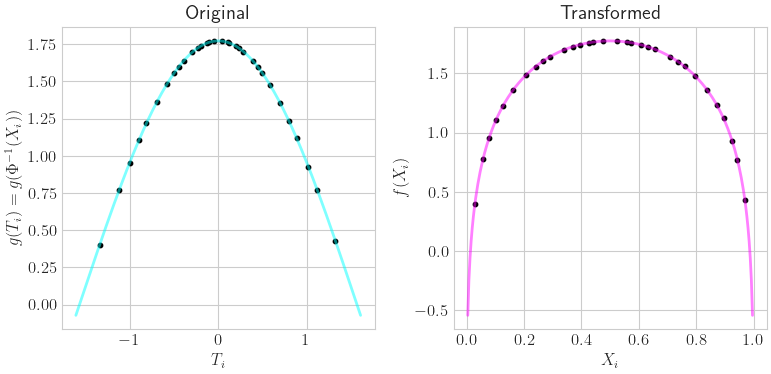

In [21]:
n = 32
keister = qp.Keister(qp.DigitalNetB2(1))
fig,ax = pyplot.subplots(nrows=1,ncols=2,figsize=(8,4))
x = keister.discrete_distrib.gen_samples(n)
t = keister.true_measure.gen_samples(n)
f_of_x = keister.f(x).squeeze()
g_of_t = keister.g(t).squeeze()
assert (f_of_x==g_of_t).all()
x_fine = np.linspace(0,1,257)[1:-1,None]
f_of_xfine = keister.f(x_fine).squeeze()
lb = 1.2*max(abs(t.min()),abs(t.max()))
t_fine = np.linspace(-lb,lb,257)[:,None]
g_of_tfine = keister.g(t_fine).squeeze()
ax[0].set_title(r'Original')
ax[0].set_xlabel(r'$T_i$'); ax[0].set_ylabel(r'$g(T_i) = g(\Phi^{-1}(X_i))$')
ax[0].plot(t_fine.squeeze(),g_of_tfine,color=colors[0],alpha=.5)
ax[0].scatter(t.squeeze(),f_of_x,s=10,color='k')
ax[1].set_title(r'Transformed')
ax[1].set_xlabel(r'$X_i$'); ax[1].set_ylabel(r'$f(X_i)$')
ax[1].scatter(x.squeeze(),f_of_x,s=10,color='k')
ax[1].plot(x_fine.squeeze(),f_of_xfine,color=colors[1],alpha=.5);

## Stopping Criterion

Adaptively increase $n$ until $\lvert \mu - \hat{\mu} \rvert < \varepsilon$ where $\varepsilon$ is a user defined tolerance. 

The stopping criterion should match the discrete distribution e.g. IID CMC stopping criterion for IID points, QMC Lattice stopping criterion for LD Lattice points, QMC digital net stopping criterion for LD digital net points, etc. 

### IID CMC Algorithm

In [22]:
problem_cmc = qp.AsianOption(qp.IIDStdUniform(52))
cmc_stop_crit = qp.CubMCG(problem_cmc,abs_tol=0.025)
approx_cmc,data_cmc = cmc_stop_crit.integrate()
data_cmc

MeanVarData (AccumulateData Object)
    solution        1.781
    error_bound     0.025
    n_total         376088
    n               375064
    levels          1
    time_integrate  2.086
CubMCG (StoppingCriterion Object)
    abs_tol         0.025
    rel_tol         0
    n_init          2^(10)
    n_max           10000000000
    inflate         1.200
    alpha           0.010
AsianOption (Integrand Object)
    volatility      2^(-1)
    call_put        call
    start_price     30
    strike_price    35
    interest_rate   0
    mean_type       arithmetic
    dim_frac        0
BrownianMotion (TrueMeasure Object)
    time_vec        [0.019 0.038 0.058 ... 0.962 0.981 1.   ]
    drift           0
    mean            [0. 0. 0. ... 0. 0. 0.]
    covariance      [[0.019 0.019 0.019 ... 0.019 0.019 0.019]
                    [0.019 0.038 0.038 ... 0.038 0.038 0.038]
                    [0.019 0.038 0.058 ... 0.058 0.058 0.058]
                    ...
                    [0.019 0.038 0.058

### LD QMC Algorithm

In [23]:
problem_qmc = qp.AsianOption(qp.DigitalNetB2(52))
qmc_stop_crit = qp.CubQMCNetG(problem_qmc,abs_tol=0.025)
approx_qmc,data_qmc = qmc_stop_crit.integrate()
data_qmc

LDTransformData (AccumulateData Object)
    solution        1.788
    comb_bound_low  1.774
    comb_bound_high 1.802
    comb_flags      1
    n_total         2^(11)
    n               2^(11)
    time_integrate  0.011
CubQMCNetG (StoppingCriterion Object)
    abs_tol         0.025
    rel_tol         0
    n_init          2^(10)
    n_max           2^(35)
AsianOption (Integrand Object)
    volatility      2^(-1)
    call_put        call
    start_price     30
    strike_price    35
    interest_rate   0
    mean_type       arithmetic
    dim_frac        0
BrownianMotion (TrueMeasure Object)
    time_vec        [0.019 0.038 0.058 ... 0.962 0.981 1.   ]
    drift           0
    mean            [0. 0. 0. ... 0. 0. 0.]
    covariance      [[0.019 0.019 0.019 ... 0.019 0.019 0.019]
                    [0.019 0.038 0.038 ... 0.038 0.038 0.038]
                    [0.019 0.038 0.058 ... 0.058 0.058 0.058]
                    ...
                    [0.019 0.038 0.058 ... 0.962 0.962 0.962]

In [24]:
print('QMC took %.2f%% the time and %.2f%% the samples compared to CMC'%(
      100*data_qmc.time_integrate/data_cmc.time_integrate,100*data_qmc.n_total/data_cmc.n_total))

QMC took 0.52% the time and 0.54% the samples compared to CMC


### Visual CMC vs LD

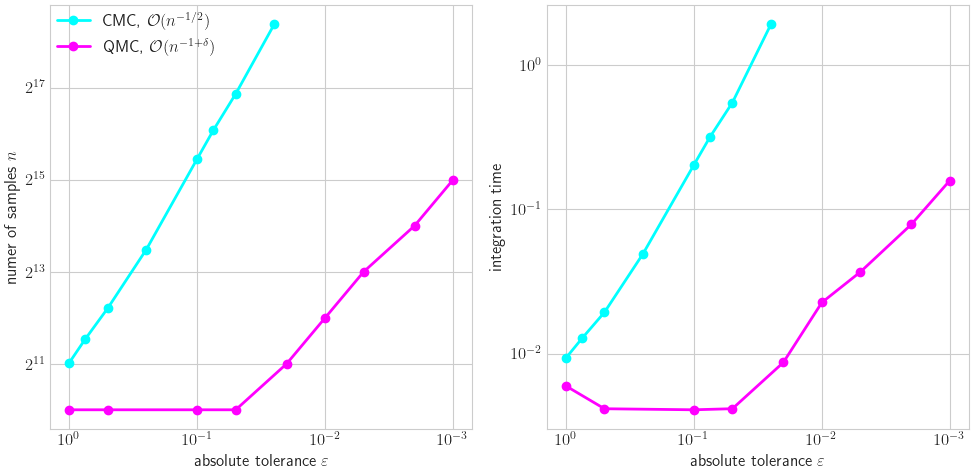

In [25]:
cmc_tols = [1,.75,.5,.25,.1,.075,.05,.025]
qmc_tols = [1,.5,.1,.05,.02,.01,.005,.002,.001]
fig,ax = pyplot.subplots(nrows=1,ncols=2,figsize=(10,5))
n_cmc,time_cmc = np.zeros_like(cmc_tols),np.zeros_like(cmc_tols)
for i,cmc_tol in enumerate(cmc_tols):
    cmc_stop_crit = qp.CubMCG( qp.AsianOption(qp.IIDStdUniform(52)),abs_tol=cmc_tol)
    approx_cmc,data_cmc = cmc_stop_crit.integrate()
    n_cmc[i],time_cmc[i] = data_cmc.n_total,data_cmc.time_integrate
ax[0].plot(cmc_tols,n_cmc,'-o',color=colors[0],label=r'CMC, $\mathcal{O}(n^{-1/2})$')
ax[1].plot(cmc_tols,time_cmc,'-o',color=colors[0])
n_qmc,time_qmc = np.zeros_like(qmc_tols),np.zeros_like(qmc_tols)
for i,qmc_tol in enumerate(qmc_tols):
    qmc_stop_crit = qp.CubQMCNetG(qp.AsianOption(qp.DigitalNetB2(52)),abs_tol=qmc_tol)
    approx_qmc,data_qmc = qmc_stop_crit.integrate()
    n_qmc[i],time_qmc[i] = data_qmc.n_total,data_qmc.time_integrate
ax[0].plot(qmc_tols,n_qmc,'-o',color=colors[1],label=r'QMC, $\mathcal{O}(n^{-1+\delta})$')
ax[1].plot(qmc_tols,time_qmc,'-o',color=colors[1])
ax[0].set_xscale('log',base=10); ax[0].set_yscale('log',base=2)
ax[1].set_xscale('log',base=10); ax[1].set_yscale('log',base=10)
ax[0].invert_xaxis(); ax[1].invert_xaxis()
ax[0].set_xlabel(r'absolute tolerance $\varepsilon$'); ax[1].set_xlabel(r'absolute tolerance $\varepsilon$')
ax[0].set_ylabel(r'numer of samples $n$'); ax[1].set_ylabel('integration time')
ax[0].legend(loc='upper left');

## Vectorized Stopping Criterion

Many more examples available at https://github.com/QMCSoftware/QMCSoftware/blob/master/demos/vectorized_qmc.ipynb

### Vector of Expectations

As a simple example, lets compute $\mathbb{E}[\cos(P)]$ and $\mathbb{E}[\sin(P)]$ where $P=T_0\cdots T_{d-1}$ and $T \sim \mathcal{U}[0,\pi]^d$

In [74]:
qmc_stop_crit = qp.CubQMCCLT(
    integrand = qp.CustomFun(
        true_measure = qp.Uniform(sampler=qp.Halton(3),lower_bound=0,upper_bound=np.pi),
        g = lambda t,compute_flags: np.vstack([np.cos(t).prod(1),np.sin(t).prod(1)]).T,
        dimension_indv = 2),
    abs_tol=.0001)
approx,data = qmc_stop_crit.integrate()
data

MeanVarDataRep (AccumulateData Object)
    solution        [5.48e-06 2.58e-01]
    comb_bound_low  [-7.498e-05  2.580e-01]
    comb_bound_high [8.593e-05 2.581e-01]
    comb_flags      [ True  True]
    n_total         2^(18)
    n               [262144. 131072.]
    n_rep           [16384.  8192.]
    time_integrate  0.210
CubQMCCLT (StoppingCriterion Object)
    inflate         1.200
    alpha           0.010
    abs_tol         1.00e-04
    rel_tol         0
    n_init          2^(8)
    n_max           2^(30)
    replications    2^(4)
CustomFun (Integrand Object)
Uniform (TrueMeasure Object)
    lower_bound     0
    upper_bound     3.142
Halton (DiscreteDistribution Object)
    d               3
    dvec            [0 1 2]
    randomize       QRNG
    generalize      1
    entropy         287938327812346013878581971057884214725
    spawn_key       ()

### Covariance

In a simple example, let $T \sim \mathcal{N}(1,I_d)$ and compute the covariance of $P = T_0\cdots T_{d-1}$ and $S = T_0+\dots+T_{d-1}$ so that 
$$\mathrm{Cov}[P,S] = \mathbb{E}[PS]-\mathbb{E}[P]\mathbb{E}[S] = \mu_0-\mu_1\mu_2$$
Theoretically we have $\mathrm{Cov}[P,S] = 2d-(1)(d) = d$

In [48]:
class CovIntegrand(qp.integrand.Integrand):
    def __init__(self,sampler):
        self.sampler = sampler
        self.true_measure = qp.Gaussian(sampler,mean=1)
        super(CovIntegrand,self).__init__(dimension_indv=3,dimension_comb=1,parallel=False)
    def g(self, t, compute_flags):
        y = np.zeros((len(t),3))
        y[:,1] = t.prod(1) # P
        y[:,2] = t.sum(1) # S
        y[:,0] = y[:,1]*y[:,2] #PS
        return y
    def _spawn(self, level, sampler):
        return CovFun(sampler)
    def bound_fun(self, low, high):
        comb_low = low[0]-max(low[1]*low[2],low[1]*high[2],high[1]*low[2],high[1]*high[2])
        comb_high = high[0]-min(low[1]*low[2],low[1]*high[2],high[1]*low[2],high[1]*high[2])
        return comb_low,comb_high
    def dependency(self, comb_flag):
        return np.tile(comb_flag,3)
approx,data = qp.CubQMCLatticeG(CovIntegrand(qp.Lattice(10)),rel_tol=.05).integrate()
data

LDTransformData (AccumulateData Object)
    solution        9.913
    comb_bound_low  9.522
    comb_bound_high 10.344
    comb_flags      1
    n_total         2^(19)
    n               [524288. 524288. 524288.]
    time_integrate  1.601
CubQMCLatticeG (StoppingCriterion Object)
    abs_tol         0.010
    rel_tol         0.050
    n_init          2^(10)
    n_max           2^(35)
CovIntegrand (Integrand Object)
Gaussian (TrueMeasure Object)
    mean            1
    covariance      1
    decomp_type     PCA
Lattice (DiscreteDistribution Object)
    d               10
    dvec            [0 1 2 3 4 5 6 7 8 9]
    randomize       1
    order           natural
    gen_vec         [     1 182667 469891 498753 110745 446247 250185 118627 245333 283199]
    entropy         1472290663353342859031211883475350402
    spawn_key       ()

### Sensitiviy Indices

See Appendix A of [Art Owen's Monte Carlo Book](https://artowen.su.domains/mc/)

In the following example, we fit a neural network to Iris flower features and try to classify the Iris species. For each set of features, the classifier provides a probability of belonging to each species, a length 3 vector. We quantify the sensitiviy of this classificaiton probability to Iris features, assuming features are uniformly distributed throughout the feature domain.

In [94]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
data = load_iris()
og_feature_names = data["feature_names"]
feature_names = [fn.replace('sepal ','S')\
    .replace('length ','L')\
    .replace('petal ','P')\
    .replace('width ','W')\
    .replace('(cm)','') for fn in og_feature_names]
target_names = data["target_names"]
xt,xv,yt,yv = train_test_split(data["data"],data["target"],
    test_size = 1/3,
    random_state = 7)
pd.DataFrame(np.hstack([data['data'],data['target'][:,None]]),columns=og_feature_names+['species']).iloc[[0,1,90,91,140,141]]

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
90,5.5,2.6,4.4,1.2,1.0
91,6.1,3.0,4.6,1.4,1.0
140,6.7,3.1,5.6,2.4,2.0
141,6.9,3.1,5.1,2.3,2.0


In [80]:
mlpc = MLPClassifier(random_state=7,max_iter=1024).fit(xt,yt)
yhat = mlpc.predict(xv)
print("accuracy: %.1f%%"%(100*(yv==yhat).mean()))
# accuracy: 98.0%
sampler = qp.DigitalNetB2(4,seed=7)
true_measure =  qp.Uniform(sampler,
    lower_bound = xt.min(0),
    upper_bound = xt.max(0))
fun = qp.CustomFun(
    true_measure = true_measure,
    g = lambda x,compute_flags: mlpc.predict_proba(x),
    dimension_indv = 3)
si_fun = qp.SensitivityIndices(fun,indices="all")
qmc_algo = qp.CubQMCNetG(si_fun,abs_tol=.005)
nn_sis,nn_sis_data = qmc_algo.integrate()

accuracy: 98.0%


In [81]:
#print(nn_sis_data.flags_indv.shape)
#print(nn_sis_data.flags_comb.shape)
print('samples: 2^(%d)'%np.log2(nn_sis_data.n_total))
print('time: %.1e'%nn_sis_data.time_integrate)
print('indices:',nn_sis_data.integrand.indices)

import pandas as pd

df_closed = pd.DataFrame(nn_sis[0],columns=target_names,index=[str(idx) for idx in nn_sis_data.integrand.indices])
print('\nClosed Indices')
print(df_closed)
df_total = pd.DataFrame(nn_sis[1],columns=target_names,index=[str(idx) for idx in nn_sis_data.integrand.indices])
print('\nTotal Indices')
print(df_total)
df_closed_singletons = df_closed.T.iloc[:,:4]
df_closed_singletons['sum singletons'] = df_closed_singletons[['[%d]'%i for i in range(4)]].sum(1)
df_closed_singletons.columns = data['feature_names']+['sum']
df_closed_singletons = df_closed_singletons*100

samples: 2^(15)
time: 1.9e+00
indices: [[0], [1], [2], [3], [0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [2, 3], [0, 1, 2], [0, 1, 3], [0, 2, 3], [1, 2, 3]]

Closed Indices
             setosa  versicolor  virginica
[0]        0.001504    0.071122   0.081736
[1]        0.058743    0.022073   0.010373
[2]        0.713777    0.328313   0.500059
[3]        0.046053    0.021077   0.120233
[0, 1]     0.059178    0.091764   0.098233
[0, 2]     0.715117    0.460138   0.642551
[0, 3]     0.046859    0.092322   0.207724
[1, 2]     0.843241    0.434629   0.520469
[1, 3]     0.108872    0.039572   0.127844
[2, 3]     0.823394    0.582389   0.705354
[0, 1, 2]  0.845359    0.570022   0.661100
[0, 1, 3]  0.108503    0.106081   0.218971
[0, 2, 3]  0.825389    0.814286   0.948331
[1, 2, 3]  0.996483    0.738213   0.729940

Total Indices
             setosa  versicolor  virginica
[0]        0.003199    0.259762   0.265085
[1]        0.172391    0.183159   0.045582
[2]        0.889677    0.896874   0.780377


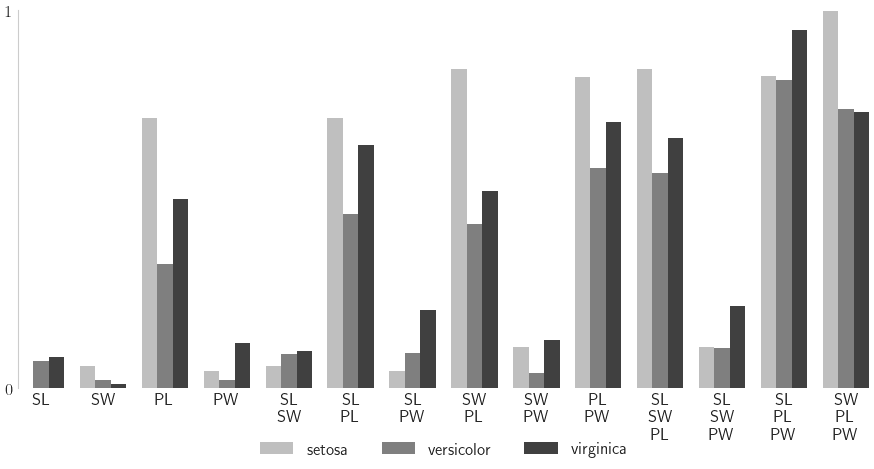

In [83]:
nindices = len(nn_sis_data.integrand.indices)
fig,ax = pyplot.subplots(figsize=(9,5))
ticks = np.arange(nindices)
width = .25
for i,(alpha,species) in enumerate(zip([.25,.5,.75],data['target_names'])):
    cvals = df_closed[species].to_numpy()
    tvals = df_total[species].to_numpy()
    ticks_i = ticks+i*width
    ax.bar(ticks_i,cvals,width=width,align='edge',color='k',alpha=alpha,label=species)
    #ax.bar(ticks_i,np.flip(tvals),width=width,align='edge',bottom=1-np.flip(tvals),color=color,alpha=.1)
ax.set_xlim([0,13+3*width])
ax.set_xticks(ticks+1.5*width)

# closed_labels = [r'$\underline{s}_{\{%s\}}$'%(','.join([r'\text{%s}'%feature_names[i] for i in idx])) for idx in nn_sis_data.integrand.indices]
closed_labels = ['\n'.join([feature_names[i] for i in idx]) for idx in nn_sis_data.integrand.indices]
ax.set_xticklabels(closed_labels,rotation=0)
ax.set_ylim([0,1]); ax.set_yticks([0,1])
ax.grid(False)
for spine in ['top','right','bottom']: ax.spines[spine].set_visible(False)
ax.legend(frameon=False,loc='lower center',bbox_to_anchor=(.5,-.2),ncol=3);